In [152]:
from atm_data.data_utils.weather_noaa_data import *
from pathlib import Path
from ast import literal_eval
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [195]:
data_dir = Path.cwd().resolve().parent / 'data'
weather_path = data_dir / 'noaa_lcdv2/lcd_lga_1987-2023_cleaned.parquet'
schedule_path = data_dir / 'bts_remapped/lga_reduced_2010-2019_clean_yearly/parquet/lga_reduced_2019_clean.parquet'

# start_date = "2019-07-01"
# end_date = "2019-08-01" # exclusive

start_date = "2019-01-01"
end_date = "2020-01-01" # exclusive

wdf = pd.read_parquet(weather_path)
sdf = pd.read_parquet(schedule_path)
sdf = (
    sdf.set_index(
        pd.DatetimeIndex(sdf['date'])
    )
    .drop(['date'], axis=1)
)

wdf = wdf.loc[(wdf.index >= start_date) & (wdf.index < end_date)]
sdf = sdf.loc[(sdf.index >= start_date) & (sdf.index < end_date)]

for df in (wdf, sdf):
    display(df)
    display(df.dtypes)


,hourly_alitmeter_setting,hourly_dew_point_temperature,hourly_dry_bulb_temperature,hourly_precipitation,hourly_relative_humidity,hourly_visibility,hourly_wind_direction,hourly_wind_speed,hourly_wind_gust_speed,hourly_present_weather_type,...,hsc_layer_1_height,hsc_layer_2_height,hsc_layer_3_height,hsc_total_coverage,hsc_total_amount,hsc_total_height,hsc_ceiling_coverage,hsc_ceiling_amount,hsc_ceiling_height,hourly_sky_conditions
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1007.5,7.8,8.3,1.5,97.0,6.437,60.0,0.0,0.0,"[BR, RA]",...,1.22,NaN,NaN,OVC,8.0,1.22,OVC,8.0,1.22,OVC:08-1.22
2019-01-01 01:00:00,1005.1,8.9,10.0,0.5,93.0,6.437,200.0,2.1,0.0,"[BR, RA]",...,2.74,3.35,NaN,OVC,8.0,3.35,BKN,7.0,2.74,BKN:07-2.74 OVC:08-3.35
2019-01-01 02:00:00,1003.0,9.4,10.6,0.0,92.0,6.437,190.0,3.6,0.0,[BR],...,1.52,NaN,NaN,OVC,8.0,1.52,OVC,8.0,1.52,OVC:08-1.52
2019-01-01 03:00:00,1003.0,11.1,12.2,0.0,93.0,4.828,250.0,6.7,0.0,[BR],...,1.22,NaN,NaN,OVC,8.0,1.22,OVC,8.0,1.22,OVC:08-1.22
2019-01-01 04:00:00,1002.0,11.1,12.8,0.0,90.0,8.047,250.0,6.7,13.9,[BR],...,2.13,NaN,NaN,OVC,8.0,2.13,OVC,8.0,2.13,OVC:08-2.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1003.0,1.7,7.2,0.0,68.0,16.093,210.0,4.6,0.0,[],...,15.24,18.29,NaN,OVC,8.0,18.29,BKN,7.0,15.24,BKN:07-15.24 OVC:08-18.29
2019-12-31 20:00:00,1004.1,1.1,6.7,0.3,68.0,16.093,280.0,7.2,12.4,[RA],...,8.23,10.06,14.94,OVC,8.0,14.94,OVC,8.0,14.94,FEW:02-8.23 SCT:04-10.06 OVC:08-14.94
2019-12-31 21:00:00,1003.7,0.0,6.1,0.0,65.0,16.093,270.0,6.2,10.8,[RA],...,8.23,16.76,NaN,OVC,8.0,16.76,OVC,8.0,16.76,FEW:02-8.23 OVC:08-16.76


hourly_alitmeter_setting         float64
hourly_dew_point_temperature     float64
hourly_dry_bulb_temperature      float64
hourly_precipitation             float64
hourly_relative_humidity         float64
hourly_visibility                float64
hourly_wind_direction            float64
hourly_wind_speed                float64
hourly_wind_gust_speed           float64
hourly_present_weather_type       object
hpwt_BCFG                        boolean
hpwt_BL                          boolean
hpwt_BLSN                        boolean
hpwt_BR                          boolean
hpwt_DRSN                        boolean
hpwt_DZ                          boolean
hpwt_FG                          boolean
hpwt_FU                          boolean
hpwt_FZDZ                        boolean
hpwt_FZFG                        boolean
hpwt_FZRA                        boolean
hpwt_GR                          boolean
hpwt_GS                          boolean
hpwt_HAIL                        boolean
hpwt_HZ         

,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_off_time,wheels_on_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,cancellation_code,diverted,diverted_reached_destination,diverted_airport_landings
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,AA:1597,N921AN,LGA,DFW,5.500000,9.666667,5.550000,10.333333,6.016667,9.833333,...,0.050000,0.0,0.616667,0.0,0.0,False,Z,False,<NA>,0
2019-01-01,UA:657,N26210,LGA,IAH,5.750000,9.650000,5.750000,9.683333,6.050000,9.616667,...,0.000000,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-01-01,AA:1249,N956AN,LGA,MIA,5.916667,9.166667,5.850000,9.200000,6.266667,8.966667,...,0.000000,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-01-01,AA:2154,N747UW,LGA,BOS,6.000000,7.100000,5.916667,7.116667,6.200000,6.883333,...,0.000000,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-01-01,WN:1165,N705SW,LGA,MDW,6.000000,8.333333,6.166667,8.600000,6.366667,8.550000,...,0.166667,0.0,0.100000,0.0,0.0,False,Z,False,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,B6:1332,N328JB,LGA,BOS,21.500000,22.683333,21.200000,22.250000,21.400000,22.100000,...,0.000000,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,B6:1431,N198JB,BOS,LGA,21.500000,22.783333,21.616667,22.516667,21.850000,22.483333,...,0.000000,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,DL:2814,N321DH,ATL,LGA,21.500000,23.633333,21.466667,23.350000,21.650000,23.233333,...,0.000000,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0


flight_number                   string[python]
tail_number                     string[python]
origin_airport                  string[python]
destination_airport             string[python]
scheduled_departure_time               float64
scheduled_arrival_time                 float64
actual_departure_time                  float64
actual_arrival_time                    float64
wheels_off_time                        float64
wheels_on_time                         float64
departure_delay                        float64
arrival_delay                          float64
carrier_delay                          float64
weather_delay                          float64
nas_delay                              float64
security_delay                         float64
late_aircraft_delay                    float64
cancelled                              boolean
cancellation_code                     category
diverted                               boolean
diverted_reached_destination           boolean
diverted_airp

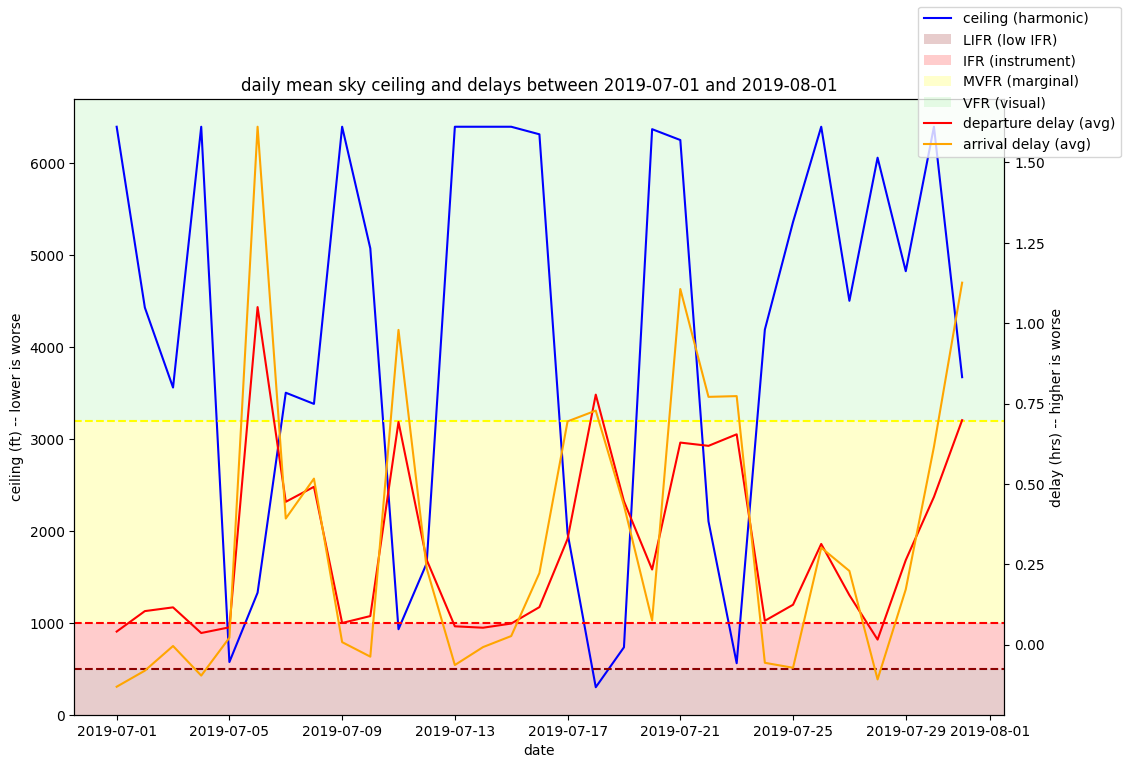

In [279]:
freq='1D'

ch_daily_finite_mean = (
    wdf.hsc_ceiling_height    
    .loc[~wdf.hsc_ceiling_height.isin([np.inf, np.nan])]
    .groupby(pd.Grouper(freq=freq))
    .mean()
)

ch_daily_min = (
    wdf.hsc_ceiling_height    
    .groupby(pd.Grouper(freq=freq))
    .min()
)

# probably not a term?
ch_daily_inverse_mean = (
    (1.0 / wdf.hsc_ceiling_height)    
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_harmonic_mean = (
    1.0 / ch_daily_inverse_mean
)

# ch_hourly_clipped = df.hsc_ceiling_height.clip(lower=10, upper=32)
ch_hourly_clipped = wdf.hsc_ceiling_height.clip(lower=.5, upper=64)

ch_daily_clipped_mean = (
    ch_hourly_clipped
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_clipped_inverse_mean = (
    (1.0 / ch_hourly_clipped)    
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_clipped_harmonic_mean = (
    1.0 / ch_daily_clipped_inverse_mean
)
# ch_daily_clipped_harmonic_mean = ch_hourly_clipped.groupby(pd.Grouper(freq=freq)).min()

# display(ch_daily_clipped_harmonic_mean.nsmallest(5))

sdf_outgoing = sdf.loc[sdf.origin_airport == 'LGA']
sdf_incoming = sdf.loc[sdf.destination_airport == 'LGA']

dep_delay_daily = sdf_outgoing.departure_delay.groupby(pd.Grouper(freq=freq)).mean()
arr_delay_daily = sdf_incoming.arrival_delay.groupby(pd.Grouper(freq=freq)).mean()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

start = '2019-07-01'
end = '2019-08-01'
v = 100 * ch_daily_clipped_harmonic_mean.loc[
    (start <= ch_daily_clipped_harmonic_mean.index) 
    & (ch_daily_clipped_harmonic_mean.index < end)
]
d = dep_delay_daily.loc[
    (start <= dep_delay_daily.index)
    & (dep_delay_daily.index < end)
]
a = arr_delay_daily.loc[
    (start <= arr_delay_daily.index)
     & (arr_delay_daily.index < end)
]

ax2 = ax.twinx()
# plt.plot(ch_daily_clipped_mean, label='straight')
ax.plot(v, color='blue', label='ceiling (harmonic)')
ax2.plot(d, color='red', label='departure delay (avg)')
ax2.plot(a, color='orange', label='arrival delay (avg)')

ax.set_ylabel('ceiling (ft) -- lower is worse')
ax2.set_ylabel('delay (hrs) -- higher is worse')
ax.set_xlabel('date')
ax.set_title(f'daily mean sky ceiling and delays between {start} and {end}')

# ax.set_ylim(top=6400)
ax.set_ylim(bottom=0)
# ax2.set_ylim(bottom=-.05)

ax.axhline(500, color='darkred', linestyle='--')
ax.axhline(1000, color='red', linestyle='--')
ax.axhline(3200, color='yellow', linestyle='--')

alpha = .2
ax.axhspan(0, 500, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axhspan(500, 1000, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axhspan(1000, 3200, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axhspan(3200, ax.get_ylim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

# ax.legend()
# ax2.legend()
fig.legend()




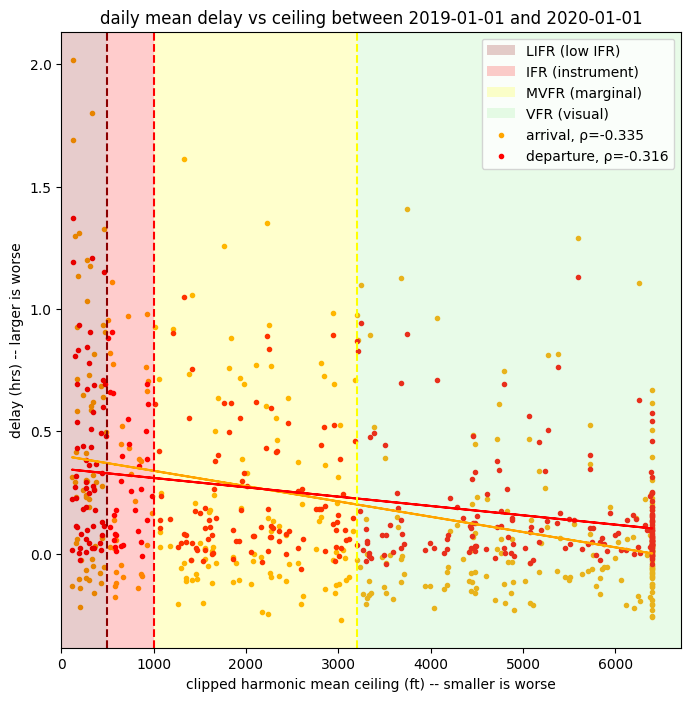

In [280]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

def plot_scatter_and_trend(ax, x, y, color, linestyle='-', marker='.', label=None, d=1):        
    ax.scatter(x, y, color=c, marker=marker, label=label)
    z = np.polyfit(x, y, deg=d)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=color, linestyle=linestyle)

# x = v
# for y, c, l in ((a, 'orange', 'arrival'), (d, 'red', 'departure')):
x = 100 * ch_daily_clipped_harmonic_mean
for y, c, l in ((arr_delay_daily, 'orange', 'arrival'), (dep_delay_daily, 'red', 'departure')):
    r, _ = pearsonr(x, y)
    plot_scatter_and_trend(ax, x.to_numpy(), y.to_numpy(), c, label=f'{l}, ρ={r:.03f}')

ax.set_xlim(left=0)

ax.axvline(500, color='darkred', linestyle='--')
ax.axvline(1000, color='red', linestyle='--')
ax.axvline(3200, color='yellow', linestyle='--')

alpha = .2
ax.axvspan(0, 500, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axvspan(500, 1000, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axvspan(1000, 3200, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axvspan(3200, ax.get_xlim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

ax.set_xlabel('clipped harmonic mean ceiling (ft) -- smaller is worse')
ax.set_ylabel('delay (hrs) -- larger is worse')
ax.set_title(f'daily mean delay vs ceiling between {start_date} and {end_date}')

ax.legend()

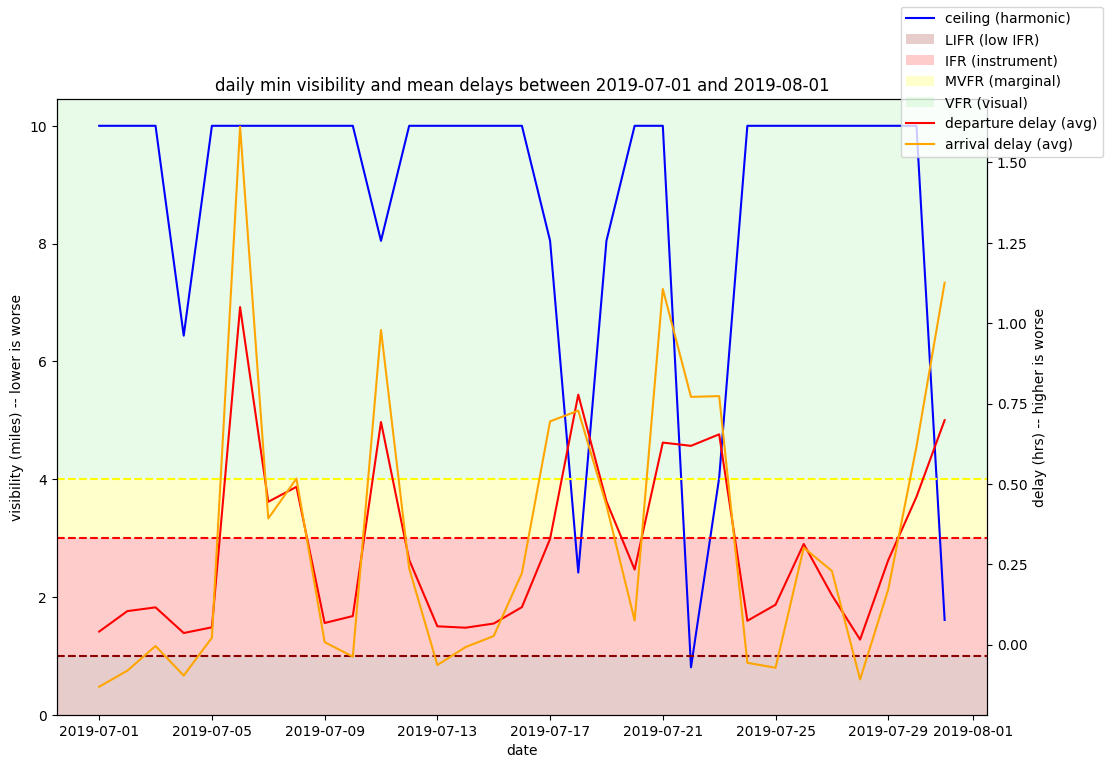

In [281]:
# TODO: make a function and not just have this copied lol

ch_hourly_clipped = wdf.hourly_visibility.clip(lower=.001, upper=10)

ch_daily_clipped_mean = (
    ch_hourly_clipped
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_clipped_inverse_mean = (
    (1.0 / ch_hourly_clipped)    
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_clipped_harmonic_mean = (
    1.0 / ch_daily_clipped_inverse_mean
)

ch_daily_clipped_harmonic_mean = (ch_hourly_clipped.groupby(pd.Grouper(freq=freq)).min())

# display(ch_daily_clipped_harmonic_mean.nsmallest(5))

sdf_outgoing = sdf.loc[sdf.origin_airport == 'LGA']
sdf_incoming = sdf.loc[sdf.destination_airport == 'LGA']

dep_delay_daily = sdf_outgoing.departure_delay.groupby(pd.Grouper(freq=freq)).mean()
arr_delay_daily = sdf_incoming.arrival_delay.groupby(pd.Grouper(freq=freq)).mean()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

start = '2019-07-01'
end = '2019-08-01'
v = ch_daily_clipped_harmonic_mean.loc[
    (start <= ch_daily_clipped_harmonic_mean.index) 
    & (ch_daily_clipped_harmonic_mean.index < end)
]
d = dep_delay_daily.loc[
    (start <= dep_delay_daily.index)
    & (dep_delay_daily.index < end)
]
a = arr_delay_daily.loc[
    (start <= arr_delay_daily.index)
     & (arr_delay_daily.index < end)
]

ax2 = ax.twinx()
# plt.plot(ch_daily_clipped_mean, label='straight')
ax.plot(v, color='blue', label='ceiling (harmonic)')
ax2.plot(d, color='red', label='departure delay (avg)')
ax2.plot(a, color='orange', label='arrival delay (avg)')

ax.set_ylabel('visibility (miles) -- lower is worse')
ax2.set_ylabel('delay (hrs) -- higher is worse')
ax.set_xlabel('date')
ax.set_title(f'daily min visibility and mean delays between {start} and {end}')

# ax.set_ylim(top=6400)
ax.set_ylim(bottom=0)
# ax2.set_ylim(bottom=-.05)

ax.axhline(1, color='darkred', linestyle='--')
ax.axhline(3, color='red', linestyle='--')
ax.axhline(4, color='yellow', linestyle='--')

alpha = .2
ax.axhspan(0, 1, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axhspan(1, 3, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axhspan(3, 4, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axhspan(4, ax.get_ylim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

# ax.legend()
# ax2.legend()
fig.legend()




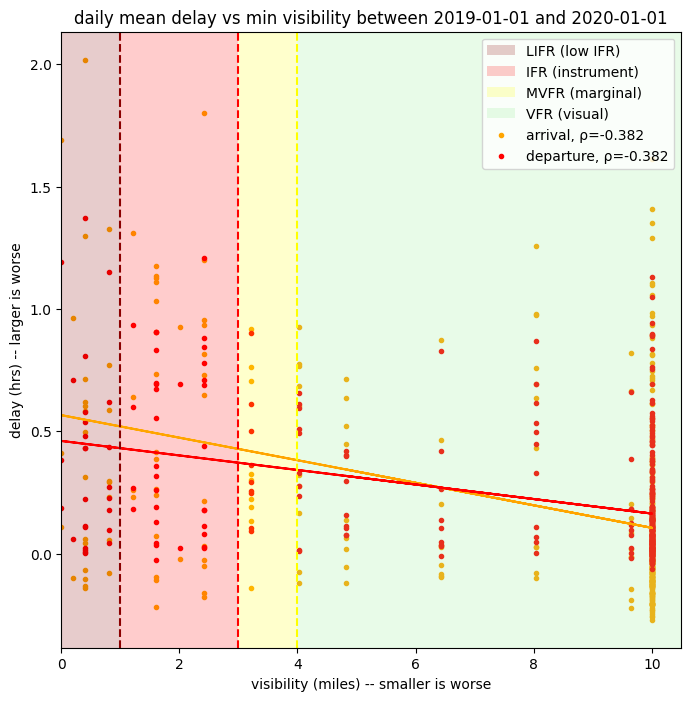

In [282]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

def plot_scatter_and_trend(ax, x, y, color, linestyle='-', marker='.', label=None, d=1):        
    ax.scatter(x, y, color=c, marker=marker, label=label)
    z = np.polyfit(x, y, deg=d)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=color, linestyle=linestyle)

# x = v
# for y, c, l in ((a, 'orange', 'arrival'), (d, 'red', 'departure')):
x = ch_daily_clipped_harmonic_mean
for y, c, l in ((arr_delay_daily, 'orange', 'arrival'), (dep_delay_daily, 'red', 'departure')):
    r, _ = pearsonr(x, y)
    plot_scatter_and_trend(ax, x.to_numpy(), y.to_numpy(), c, label=f'{l}, ρ={r:.03f}')

ax.set_xlim(left=0)

ax.axvline(1, color='darkred', linestyle='--')
ax.axvline(3, color='red', linestyle='--')
ax.axvline(4, color='yellow', linestyle='--')

alpha = .2
ax.axvspan(0, 1, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axvspan(1, 3, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axvspan(3, 4, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axvspan(4, ax.get_xlim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

ax.set_xlabel('visibility (miles) -- smaller is worse')
ax.set_ylabel('delay (hrs) -- larger is worse')
ax.set_title(f'daily mean delay vs min visibility between {start_date} and {end_date}')

ax.legend()